# Example: Regression with `QNNRegressor`



## Imports

In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt

from squlearn import Executor
from squlearn.observables import IsingHamiltonian
from squlearn.qnn import QNNRegressor, SquaredLoss
from squlearn.optimizers import SLSQP, Adam
from src.squlearn.encoding_circuit import ChebyshevRx
from src.squlearn.optimizers import SGLBO

We will use Qiskit's `StatevectorSimulator` for trainning.

In [2]:
executor = Executor("statevector_simulator")
#executor.set_shots(10000)

### BO Settings

In [3]:
x0 = [[i * 0.005] for i in range(60)]
options = {"bo_aqc_func":"EI", "bo_aqc_optimizer":"lbfgs", "bo_bounds":[(0.0, 0.3)], "log_file":"log_1", "bo_n_calls": 100, "bo_x0_points": x0, "maxiter": 400, "bo_bounds_fac": 0}

## `QNNRegressor` Setup

We start by defining a parameterized quantum circuit (PQC)

In [4]:

nqubits = 4
number_of_layers = 2

pqc = ChebyshevRx(nqubits, 1, num_layers=number_of_layers)

We also need an observable

In [5]:
ising_op = IsingHamiltonian(nqubits, I="S", Z="S", ZZ="S")
print(ising_op)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'IZZI', 'ZIIZ', 'ZIZI', 'ZZII'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[1]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[1]), ParameterExpression(1.0*p[2]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[2]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[2]),
 ParameterExpression(1.0*p[2])])


Now we can create the `QNNRegressor` with the PQC and cost operator. We also specify `SquaredLoss` and `SLSQP` as the loss function and optimizer respectively. Finally we specify random initial parameters for both, the PQC and cost operator.

In [6]:
np.random.seed(13)
param_ini = np.random.rand(pqc.num_parameters)
param_op_ini = np.random.rand(ising_op.num_parameters)

reg = QNNRegressor(pqc, ising_op, executor, SquaredLoss(), SGLBO(options), param_ini, param_op_ini)

## Training

Now we are ready to train the model to fit the logarithm funciton

In [7]:
x_space = np.arange(0.1, 0.9, 0.1)
ref_values = np.log(x_space)

reg.fit(x_space, ref_values)

fit:   0%|          | 0/400 [00:00<?, ?it/s]BOP  fval:  15.064846438837378  x:  [0.0]
BOP  fval:  12.440652692933586  x:  [0.005]
BOP  fval:  10.112249505609428  x:  [0.01]
BOP  fval:  8.085618344706814  x:  [0.015]
BOP  fval:  6.363947899690034  x:  [0.02]
BOP  fval:  4.947744935768741  x:  [0.024999999999999998]
BOP  fval:  3.834960860151986  x:  [0.03]
BOP  fval:  3.0211343390023226  x:  [0.034999999999999996]
BOP  fval:  2.499550715551977  x:  [0.04]
BOP  fval:  2.2614191679107396  x:  [0.045]
BOP  fval:  2.2960684942446488  x:  [0.049999999999999996]
BOP  fval:  2.5911621247613024  x:  [0.05499999999999999]
BOP  fval:  3.132932453144149  x:  [0.06]
BOP  fval:  3.906433890542713  x:  [0.065]
BOP  fval:  4.895813224203227  x:  [0.06999999999999999]
BOP  fval:  6.084594974297077  x:  [0.075]
BOP  fval:  7.45597855931422  x:  [0.08]
BOP  fval:  8.99314327937423  x:  [0.08499999999999999]
BOP  fval:  10.67955648320658  x:  [0.09]
BOP  fval:  12.49927986600411  x:  [0.09499999999999999]

## Evaluation

Let's check the trained parameters of the PQC and operator

In [8]:
print("Result PQC params:", reg.param)
print("Result operator params:", reg.param_op)

Result PQC params: [ 1.10128866  0.25320218  1.20788467  1.01152415  1.00571854  0.72140957
  0.72485528  0.33208254  0.37264725  1.02862154  0.20727349  0.34422442
 -0.87264139  0.70547055  0.56884923  0.23640398]
Result operator params: [-0.96183373  1.61858149  1.3537714 ]


Also let's plot the predicted function vs. the actual logarithm function

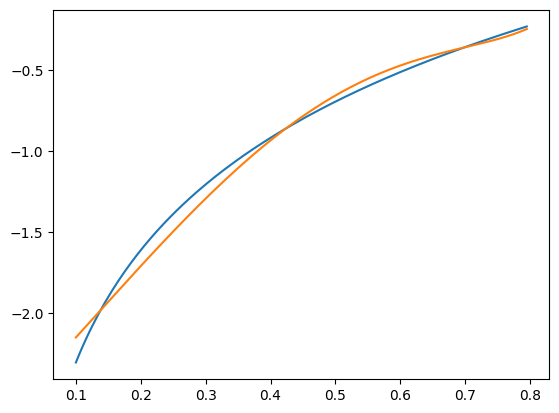

In [9]:
x = np.arange(np.min(x_space), np.max(x_space), 0.005)
y = reg.predict(x)
plt.plot(x, np.log(x))
plt.plot(x, y)

Let's also plot the error of the QNN.

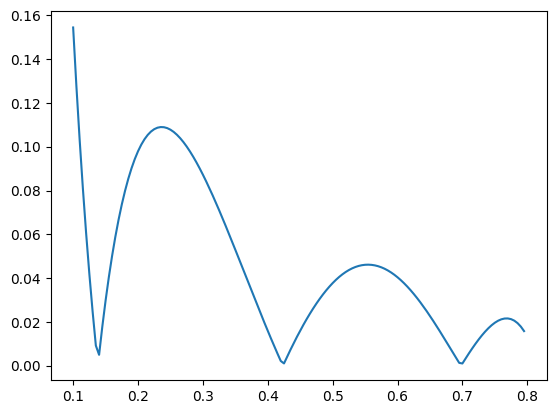

In [10]:
plt.plot(x, np.abs(y - np.log(x)))